In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [6]:
def parse_player_ids(player_page):
    #player_page = df.query("source == 'player_page'")
    player_page['player_id'] = player_page['page_url'].str[-6:]
    player_page['is_id'] = player_page['player_id'].str.contains(r'^[0-9]{6}')

    player_page['player_id'] = np.where(player_page.is_id == False, \
                                player_page['page_url'].str.split('?') \
                                        .str[0].str[-6:], player_page.player_id)
    player_page['is_id'] = player_page['player_id'].str.contains(r'^[0-9]{6}')

    player_page['player_id'] = np.where(player_page.is_id == False, \
                               player_page['page_url'].str.split('#') \
                               .str[0].str[-6:], player_page.player_id)
    player_page['is_id'] = player_page['player_id'].str.contains(r'^[0-9]{6}')

    
    player_page = player_page.query("is_id == True") # drop missing player_ids
        
    return player_page

### first predictive month for 2021

### getting quickwar data

In [2]:
quickwar = pd.read_gbq('''

WITH games AS (
SELECT DISTINCT game_pk, game_Date FROM `mlb-savant-prod-5db3.savant.onerow_per_pa`
    WHERE game_Date BETWEEN '2021-05-01' AND DATE '2021-6-30' AND game_type = 'R'
),

p AS (
 SELECT  player_id, full_name, MIN(position_name) AS position_name
FROM `mlb-datasci-prod-3f7f.player_stats.player_id`
GROUP BY 1, 2 

),

agg_hitter_stats AS (
  SELECT p.player_id
       , p.full_name AS player_name
       , EXTRACT(month FROM games.game_Date) as month
       , EXTRACT(year FROM games.game_Date) as year
       , CASE
            WHEN p.position_name = 'Outfielder' THEN 0.282
            WHEN p.position_name = 'Catcher'  THEN 0.255
            WHEN p.position_name = 'First Base' THEN 0.300
            WHEN p.position_name = 'Second Base' THEN 0.273
            WHEN p.position_name = 'Third Base' THEN 0.273
            WHEN p.position_name = 'Shortstop' THEN 0.264
            WHEN p.position_name = 'Designated Hitter' THEN 0.309
         END AS owba_constant
       , SUM(at_bats) AS at_bats
       , SUM(base_on_balls) AS base_on_balls
       , SUM(intentional_walks) AS intentional_walks
       , SUM(hit_by_pitches) AS hit_by_pitches
       , SUM(sacrifice_flies) AS sacrifice_flies
       , SUM(hits) AS hits
       , SUM(hits - (doubles + triples + home_runs)) AS singles
       , SUM(doubles) AS doubles
       , SUM(triples) AS triples
       , SUM(home_runs) AS home_runs
    FROM games
    JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_batting_stats` as batting_stats
        ON games.game_pk = batting_stats.game_pk
    JOIN p
        ON batting_stats.player_id = p.player_id
   WHERE p.position_name <> 'Pitcher'
     AND at_bats > 0
   GROUP BY 1, 2, 3, 4, 5
), hitters AS (
      SELECT player_id
           , player_name
           , month
           , year
           , at_bats
           , (
                (0.69  * (base_on_balls - intentional_walks))
              + (0.72  * hit_by_pitches)
              + (0.88  * singles)
              + (1.247 * doubles)
              + (1.578 * triples)
              + (2.031 * home_runs)
            )/(at_bats + base_on_balls - intentional_walks + sacrifice_flies + hit_by_pitches ) AS owba
           , owba_constant
        FROM agg_hitter_stats
), hitters_war AS (
      SELECT player_id
          , 'H' as pos
          , player_name
          , month
          , year
          , SUM(0.08 * at_bats * (owba - owba_constant)) AS quickwar
       FROM hitters
      GROUP BY 1, 2, 3, 4, 5
), agg_pitching_stats AS (
    SELECT p.player_id
         , p.full_name AS player_name
         , EXTRACT(month FROM games.game_Date) as month
         , EXTRACT(year FROM games.game_Date) as year
         , SUM(innings_pitched) AS innings_pitched
         , SUM(earned_runs) AS earned_runs
      FROM games
      JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_pitching_stats` AS pitching_stats
          ON games.game_pk = pitching_stats.game_pk
      JOIN p
          ON pitching_stats.player_id = p.player_id
     GROUP BY 1, 2, 3, 4
), pitcher_war AS (
      SELECT player_id
           , player_name
           , month 
           , year
           , 'P' as pos
           , ( (innings_pitched * 0.058) - (earned_runs/10.0) ) AS quickwar
        FROM agg_pitching_stats
), combined AS (
      SELECT players.player_id
           , players.player_name
           , COALESCE(hitters_war.month, pitcher_war.month) AS month
           , COALESCE(hitters_war.year, pitcher_war.year) AS year
           , COALESCE(hitters_war.pos, pitcher_war.pos) AS position
           , COALESCE(hitters_war.quickwar, 0.0) AS hitting_quickwar
           , COALESCE(pitcher_war.quickwar, 0.0) AS pitching_quickwar
           , COALESCE(hitters_war.quickwar, 0.0) + COALESCE(pitcher_war.quickwar, 0.0) AS total_quickwar
        FROM `mlb-datasci-prod-3f7f.player_avidity.most_recent_roster` AS players
   LEFT JOIN hitters_war 
           ON players.player_id = hitters_war.player_id
   LEFT JOIN pitcher_war ON players.player_id = pitcher_war.player_id
   AND hitters_war.month = pitcher_war.month
   AND hitters_war.year = pitcher_war.year
)
SELECT 
     player_id
     , player_name
     , month
     , year
     , position
     , hitting_quickwar
     , pitching_quickwar
     , total_quickwar
     , PERCENT_RANK() OVER (ORDER BY total_quickwar) AS performance_rank
  FROM combined
  
''')

Downloading: 100%|██████████| 1710/1710 [00:00<00:00, 6598.74rows/s]


### mlb player page loads

In [3]:
player_page_loads = pd.read_gbq('''
        

    WITH initial_query AS (

    SELECT DISTINCT page_url, visit, EXTRACT(month FROM date_time_date) as month,
    EXTRACT(year FROM date_time_date) as year,
    EXTRACT(month FROM date_time_date)-1 as join_month
    FROM `mlb-bdataml-prod-da8f.video_recommendation_engine_clickstream.page_loads`

        WHERE (page_url LIKE '%mlb.com/player/%')
        AND date_time_date >= '2021-7-01' AND date_time_date < '2021-08-01'
    )




        SELECT page_url, month, join_month, year, count(*) as visits
        FROM initial_query
        GROUP BY page_url, month, join_month, year
        ORDER BY 2 desc
        
        


        ''' )

Downloading: 100%|██████████| 110222/110222 [00:04<00:00, 22290.43rows/s]


In [4]:
names = []
for i in player_page_loads['page_url']:
    if '?' in i:
        m = re.search('[^\/]+(.)?\?', i)
        temp = m.group(0)
        names.append(temp[:-1])
    else:
        m = re.search('[^/]+(?=/$|$)', i)
        if '#' in m.group(0):
            n = re.search('^[^#]*',m.group(0))
            names.append(n.group(0))
        else:
            names.append(m.group(0))

In [5]:
full_player_page = player_page_loads

In [7]:
full_player_page = parse_player_ids(player_page_loads)

In [8]:
full_player_page["is_numeric"] = full_player_page["player_id"].str.isnumeric()
full_player_page = full_player_page.query('is_numeric').reset_index(drop=True)
full_player_page['player_id'] = (pd.to_numeric(full_player_page["player_id"]))
full_player_page['player_id'] = (full_player_page['player_id']).fillna(0.0).astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://urldefense.com/v3/__https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html*returning-a-view-versus-a-copy*5Cn__;IyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXHWaGMrQ$    """Entry point for launching an IPython kernel.


In [9]:
pages = full_player_page

In [10]:
pages = pages.groupby(['player_id', 'month', 'join_month', 'year'])['visits'].sum().reset_index()

In [12]:
quickwar['join_month'] = 6

In [13]:
page_merge21_2 = pages.merge(quickwar, how = 'inner', on = ['player_id', 'join_month', 'year'])

In [14]:
page_merge21_2.corr(method = 'pearson')

,player_id,month_x,join_month,year,visits,month_y,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
player_id,1.000000,NaN,NaN,NaN,-0.052886,0.006724,0.011383,-0.085437,-0.039435,-0.063709
month_x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
join_month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visits,-0.052886,NaN,NaN,NaN,1.000000,-0.009916,0.226132,0.223432,0.324210,0.198825
month_y,0.006724,NaN,NaN,NaN,-0.009916,1.000000,0.069307,-0.016836,0.050168,0.026537
hitting_quickwar,0.011383,NaN,NaN,NaN,0.226132,0.069307,1.000000,-0.079212,0.818255,0.722907
pitching_quickwar,-0.085437,NaN,NaN,NaN,0.223432,-0.016836,-0.079212,1.000000,0.508235,0.276334
total_quickwar,-0.039435,NaN,NaN,NaN,0.324210,0.050168,0.818255,0.508235,1.000000,0.783896
performance_rank,-0.063709,NaN,NaN,NaN,0.198825,0.026537,0.722907,0.276334,0.783896,1.000000


### second predictive month

In [16]:
quickwar = pd.read_gbq('''

WITH games AS (
SELECT DISTINCT game_pk, game_Date FROM `mlb-savant-prod-5db3.savant.onerow_per_pa`
    WHERE game_Date BETWEEN '2021-04-01' AND DATE '2021-5-31' AND game_type = 'R'
),

p AS (
 SELECT  player_id, full_name, MIN(position_name) AS position_name
FROM `mlb-datasci-prod-3f7f.player_stats.player_id`
GROUP BY 1, 2 

),

agg_hitter_stats AS (
  SELECT p.player_id
       , p.full_name AS player_name
       , EXTRACT(month FROM games.game_Date) as month
       , EXTRACT(year FROM games.game_Date) as year
       , CASE
            WHEN p.position_name = 'Outfielder' THEN 0.282
            WHEN p.position_name = 'Catcher'  THEN 0.255
            WHEN p.position_name = 'First Base' THEN 0.300
            WHEN p.position_name = 'Second Base' THEN 0.273
            WHEN p.position_name = 'Third Base' THEN 0.273
            WHEN p.position_name = 'Shortstop' THEN 0.264
            WHEN p.position_name = 'Designated Hitter' THEN 0.309
         END AS owba_constant
       , SUM(at_bats) AS at_bats
       , SUM(base_on_balls) AS base_on_balls
       , SUM(intentional_walks) AS intentional_walks
       , SUM(hit_by_pitches) AS hit_by_pitches
       , SUM(sacrifice_flies) AS sacrifice_flies
       , SUM(hits) AS hits
       , SUM(hits - (doubles + triples + home_runs)) AS singles
       , SUM(doubles) AS doubles
       , SUM(triples) AS triples
       , SUM(home_runs) AS home_runs
    FROM games
    JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_batting_stats` as batting_stats
        ON games.game_pk = batting_stats.game_pk
    JOIN p
        ON batting_stats.player_id = p.player_id
   WHERE p.position_name <> 'Pitcher'
     AND at_bats > 0
   GROUP BY 1, 2, 3, 4, 5
), hitters AS (
      SELECT player_id
           , player_name
           , month
           , year
           , at_bats
           , (
                (0.69  * (base_on_balls - intentional_walks))
              + (0.72  * hit_by_pitches)
              + (0.88  * singles)
              + (1.247 * doubles)
              + (1.578 * triples)
              + (2.031 * home_runs)
            )/(at_bats + base_on_balls - intentional_walks + sacrifice_flies + hit_by_pitches ) AS owba
           , owba_constant
        FROM agg_hitter_stats
), hitters_war AS (
      SELECT player_id
          , 'H' as pos
          , player_name
          , month
          , year
          , SUM(0.08 * at_bats * (owba - owba_constant)) AS quickwar
       FROM hitters
      GROUP BY 1, 2, 3, 4, 5
), agg_pitching_stats AS (
    SELECT p.player_id
         , p.full_name AS player_name
         , EXTRACT(month FROM games.game_Date) as month
         , EXTRACT(year FROM games.game_Date) as year
         , SUM(innings_pitched) AS innings_pitched
         , SUM(earned_runs) AS earned_runs
      FROM games
      JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_pitching_stats` AS pitching_stats
          ON games.game_pk = pitching_stats.game_pk
      JOIN p
          ON pitching_stats.player_id = p.player_id
     GROUP BY 1, 2, 3, 4
), pitcher_war AS (
      SELECT player_id
           , player_name
           , month 
           , year
           , 'P' as pos
           , ( (innings_pitched * 0.058) - (earned_runs/10.0) ) AS quickwar
        FROM agg_pitching_stats
), combined AS (
      SELECT players.player_id
           , players.player_name
           , COALESCE(hitters_war.month, pitcher_war.month) AS month
           , COALESCE(hitters_war.year, pitcher_war.year) AS year
           , COALESCE(hitters_war.pos, pitcher_war.pos) AS position
           , COALESCE(hitters_war.quickwar, 0.0) AS hitting_quickwar
           , COALESCE(pitcher_war.quickwar, 0.0) AS pitching_quickwar
           , COALESCE(hitters_war.quickwar, 0.0) + COALESCE(pitcher_war.quickwar, 0.0) AS total_quickwar
        FROM `mlb-datasci-prod-3f7f.player_avidity.most_recent_roster` AS players
   LEFT JOIN hitters_war 
           ON players.player_id = hitters_war.player_id
   LEFT JOIN pitcher_war ON players.player_id = pitcher_war.player_id
   AND hitters_war.month = pitcher_war.month
   AND hitters_war.year = pitcher_war.year
)
SELECT 
     player_id
     , player_name
     , month
     , year
     , position
     , hitting_quickwar
     , pitching_quickwar
     , total_quickwar
     , PERCENT_RANK() OVER (ORDER BY total_quickwar) AS performance_rank
  FROM combined
  
''')

Downloading: 100%|██████████| 1717/1717 [00:00<00:00, 7542.52rows/s]


In [17]:
player_page_loads = pd.read_gbq('''
        

    WITH initial_query AS (

    SELECT DISTINCT page_url, visit, EXTRACT(month FROM date_time_date) as month,
    EXTRACT(year FROM date_time_date) as year,
    EXTRACT(month FROM date_time_date)-1 as join_month
    FROM `mlb-bdataml-prod-da8f.video_recommendation_engine_clickstream.page_loads`

        WHERE (page_url LIKE '%mlb.com/player/%')
        AND date_time_date >= '2021-6-01' AND date_time_date < '2021-07-01'
    )




        SELECT page_url, month, join_month, year, count(*) as visits
        FROM initial_query
        GROUP BY page_url, month, join_month, year
        ORDER BY 2 desc
        
        


        ''' )

Downloading: 100%|██████████| 95709/95709 [00:04<00:00, 23153.45rows/s]


In [18]:
names = []
for i in player_page_loads['page_url']:
    if '?' in i:
        m = re.search('[^\/]+(.)?\?', i)
        temp = m.group(0)
        names.append(temp[:-1])
    else:
        m = re.search('[^/]+(?=/$|$)', i)
        if '#' in m.group(0):
            n = re.search('^[^#]*',m.group(0))
            names.append(n.group(0))
        else:
            names.append(m.group(0))

In [19]:
full_player_page = player_page_loads

In [20]:
full_player_page = parse_player_ids(player_page_loads)

In [21]:
full_player_page["is_numeric"] = full_player_page["player_id"].str.isnumeric()
full_player_page = full_player_page.query('is_numeric').reset_index(drop=True)
full_player_page['player_id'] = (pd.to_numeric(full_player_page["player_id"]))
full_player_page['player_id'] = (full_player_page['player_id']).fillna(0.0).astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://urldefense.com/v3/__https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html*returning-a-view-versus-a-copy*5Cn__;IyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXHWaGMrQ$    """Entry point for launching an IPython kernel.


In [22]:
pages = full_player_page

In [23]:
pages = pages.groupby(['player_id', 'month', 'join_month', 'year'])['visits'].sum().reset_index()

In [24]:
quickwar['join_month'] = 5

In [25]:
page_merge21_1 = pages.merge(quickwar, how = 'inner', on = ['player_id', 'join_month', 'year'])

In [27]:
page_merge21_1.corr(method = 'pearson')

,player_id,month_x,join_month,year,visits,month_y,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
player_id,1.000000,NaN,NaN,NaN,-0.053434,-0.003540,-0.011147,-0.041440,-0.034208,-0.056241
month_x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
join_month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visits,-0.053434,NaN,NaN,NaN,1.000000,0.033730,0.170956,0.318722,0.333527,0.206993
month_y,-0.003540,NaN,NaN,NaN,0.033730,1.000000,0.047043,0.032601,0.058540,0.080985
hitting_quickwar,-0.011147,NaN,NaN,NaN,0.170956,0.047043,1.000000,-0.046904,0.798097,0.741927
pitching_quickwar,-0.041440,NaN,NaN,NaN,0.318722,0.032601,-0.046904,1.000000,0.564432,0.299841
total_quickwar,-0.034208,NaN,NaN,NaN,0.333527,0.058540,0.798097,0.564432,1.000000,0.793983
performance_rank,-0.056241,NaN,NaN,NaN,0.206993,0.080985,0.741927,0.299841,0.793983,1.000000


### 2022 section

In [29]:
quickwar = pd.read_gbq('''

WITH games AS (
SELECT DISTINCT game_pk, game_Date FROM `mlb-savant-prod-5db3.savant.onerow_per_pa`
    WHERE game_Date BETWEEN '2022-05-01' AND DATE '2022-6-30' AND game_type = 'R'
),

p AS (
 SELECT  player_id, full_name, MIN(position_name) AS position_name
FROM `mlb-datasci-prod-3f7f.player_stats.player_id`
GROUP BY 1, 2 

),

agg_hitter_stats AS (
  SELECT p.player_id
       , p.full_name AS player_name
       , EXTRACT(month FROM games.game_Date) as month
       , EXTRACT(year FROM games.game_Date) as year
       , CASE
            WHEN p.position_name = 'Outfielder' THEN 0.282
            WHEN p.position_name = 'Catcher'  THEN 0.255
            WHEN p.position_name = 'First Base' THEN 0.300
            WHEN p.position_name = 'Second Base' THEN 0.273
            WHEN p.position_name = 'Third Base' THEN 0.273
            WHEN p.position_name = 'Shortstop' THEN 0.264
            WHEN p.position_name = 'Designated Hitter' THEN 0.309
         END AS owba_constant
       , SUM(at_bats) AS at_bats
       , SUM(base_on_balls) AS base_on_balls
       , SUM(intentional_walks) AS intentional_walks
       , SUM(hit_by_pitches) AS hit_by_pitches
       , SUM(sacrifice_flies) AS sacrifice_flies
       , SUM(hits) AS hits
       , SUM(hits - (doubles + triples + home_runs)) AS singles
       , SUM(doubles) AS doubles
       , SUM(triples) AS triples
       , SUM(home_runs) AS home_runs
    FROM games
    JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_batting_stats` as batting_stats
        ON games.game_pk = batting_stats.game_pk
    JOIN p
        ON batting_stats.player_id = p.player_id
   WHERE p.position_name <> 'Pitcher'
     AND at_bats > 0
   GROUP BY 1, 2, 3, 4, 5
), hitters AS (
      SELECT player_id
           , player_name
           , month
           , year
           , at_bats
           , (
                (0.69  * (base_on_balls - intentional_walks))
              + (0.72  * hit_by_pitches)
              + (0.88  * singles)
              + (1.247 * doubles)
              + (1.578 * triples)
              + (2.031 * home_runs)
            )/(at_bats + base_on_balls - intentional_walks + sacrifice_flies + hit_by_pitches ) AS owba
           , owba_constant
        FROM agg_hitter_stats
), hitters_war AS (
      SELECT player_id
          , 'H' as pos
          , player_name
          , month
          , year
          , SUM(0.08 * at_bats * (owba - owba_constant)) AS quickwar
       FROM hitters
      GROUP BY 1, 2, 3, 4, 5
), agg_pitching_stats AS (
    SELECT p.player_id
         , p.full_name AS player_name
         , EXTRACT(month FROM games.game_Date) as month
         , EXTRACT(year FROM games.game_Date) as year
         , SUM(innings_pitched) AS innings_pitched
         , SUM(earned_runs) AS earned_runs
      FROM games
      JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_pitching_stats` AS pitching_stats
          ON games.game_pk = pitching_stats.game_pk
      JOIN p
          ON pitching_stats.player_id = p.player_id
     GROUP BY 1, 2, 3, 4
), pitcher_war AS (
      SELECT player_id
           , player_name
           , month 
           , year
           , 'P' as pos
           , ( (innings_pitched * 0.058) - (earned_runs/10.0) ) AS quickwar
        FROM agg_pitching_stats
), combined AS (
      SELECT players.player_id
           , players.player_name
           , COALESCE(hitters_war.month, pitcher_war.month) AS month
           , COALESCE(hitters_war.year, pitcher_war.year) AS year
           , COALESCE(hitters_war.pos, pitcher_war.pos) AS position
           , COALESCE(hitters_war.quickwar, 0.0) AS hitting_quickwar
           , COALESCE(pitcher_war.quickwar, 0.0) AS pitching_quickwar
           , COALESCE(hitters_war.quickwar, 0.0) + COALESCE(pitcher_war.quickwar, 0.0) AS total_quickwar
        FROM `mlb-datasci-prod-3f7f.player_avidity.most_recent_roster` AS players
   LEFT JOIN hitters_war 
           ON players.player_id = hitters_war.player_id
   LEFT JOIN pitcher_war ON players.player_id = pitcher_war.player_id
   AND hitters_war.month = pitcher_war.month
   AND hitters_war.year = pitcher_war.year
)
SELECT 
     player_id
     , player_name
     , month
     , year
     , position
     , hitting_quickwar
     , pitching_quickwar
     , total_quickwar
     , PERCENT_RANK() OVER (ORDER BY total_quickwar) AS performance_rank
  FROM combined
  
''')

Downloading: 100%|██████████| 1687/1687 [00:00<00:00, 7427.08rows/s]


In [30]:
player_page_loads = pd.read_gbq('''
        

    WITH initial_query AS (

    SELECT DISTINCT page_url, visit, EXTRACT(month FROM date_time_date) as month,
    EXTRACT(year FROM date_time_date) as year,
    EXTRACT(month FROM date_time_date)-1 as join_month
    FROM `mlb-bdataml-prod-da8f.video_recommendation_engine_clickstream.page_loads`

        WHERE (page_url LIKE '%mlb.com/player/%')
        AND date_time_date >= '2022-07-01' AND date_time_date < '2022-08-01'
    )




        SELECT page_url, month, join_month, year, count(*) as visits
        FROM initial_query
        GROUP BY page_url, month, join_month, year
        ORDER BY 2 desc
        
        


        ''' )

Downloading: 100%|██████████| 320077/320077 [00:16<00:00, 19999.26rows/s]


In [31]:
names = []
for i in player_page_loads['page_url']:
    if '?' in i:
        m = re.search('[^\/]+(.)?\?', i)
        temp = m.group(0)
        names.append(temp[:-1])
    else:
        m = re.search('[^/]+(?=/$|$)', i)
        if '#' in m.group(0):
            n = re.search('^[^#]*',m.group(0))
            names.append(n.group(0))
        else:
            names.append(m.group(0))

In [32]:
full_player_page = player_page_loads

In [33]:
full_player_page = parse_player_ids(player_page_loads)

In [34]:
full_player_page["is_numeric"] = full_player_page["player_id"].str.isnumeric()
full_player_page = full_player_page.query('is_numeric').reset_index(drop=True)
full_player_page['player_id'] = (pd.to_numeric(full_player_page["player_id"]))
full_player_page['player_id'] = (full_player_page['player_id']).fillna(0.0).astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://urldefense.com/v3/__https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html*returning-a-view-versus-a-copy*5Cn__;IyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXHWaGMrQ$    """Entry point for launching an IPython kernel.


In [35]:
pages = full_player_page

In [36]:
pages = pages.groupby(['player_id', 'month', 'join_month', 'year'])['visits'].sum().reset_index()

In [37]:
quickwar['join_month'] = 6

In [38]:
page_merge22_1 = pages.merge(quickwar, how = 'inner', on = ['player_id', 'join_month', 'year'])

In [40]:
page_merge22_1.corr(method = 'pearson')

,player_id,month_x,join_month,year,visits,month_y,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
player_id,1.000000,NaN,NaN,NaN,-0.037411,0.003642,0.018730,0.052487,0.027318,-0.005349
month_x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
join_month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visits,-0.037411,NaN,NaN,NaN,1.000000,0.001560,0.316660,0.457616,0.387034,0.230776
month_y,0.003642,NaN,NaN,NaN,0.001560,1.000000,0.032367,0.039822,0.038349,0.043952
hitting_quickwar,0.018730,NaN,NaN,NaN,0.316660,0.032367,1.000000,0.081621,0.984828,0.792937
pitching_quickwar,0.052487,NaN,NaN,NaN,0.457616,0.039822,0.081621,1.000000,0.253339,0.132662
total_quickwar,0.027318,NaN,NaN,NaN,0.387034,0.038349,0.984828,0.253339,1.000000,0.792736
performance_rank,-0.005349,NaN,NaN,NaN,0.230776,0.043952,0.792937,0.132662,0.792736,1.000000


In [54]:
concatenated = pd.concat([page_merge21_1.assign(dataset='June 2021'), page_merge21_2.assign(dataset='July 2021') 
                         , page_merge22_1.assign(dataset='July 2022')])

In [55]:
concatenated.sort_values('total_quickwar', ascending = False)

,player_id,month_x,join_month,year,visits,player_name,month_y,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank,dataset
141,543760,7,6,2021,29181,Marcus Semien,5.0,H,1.926039,0.0000,1.926039,1.000000,July 2021
146,543760,6,5,2021,24772,Marcus Semien,5.0,H,1.926039,0.0000,1.926039,1.000000,June 2021
580,660271,7,6,2022,282461,Shohei Ohtani,6.0,H,0.691567,1.1936,1.885167,1.000000,July 2022
367,605540,7,6,2021,28406,Brandon Woodruff,5.0,H,0.000000,1.8548,1.854800,0.999415,July 2021
377,605540,6,5,2021,23125,Brandon Woodruff,5.0,H,0.000000,1.8548,1.854800,0.999417,June 2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,624428,7,6,2022,11708,Adam Frazier,6.0,H,-0.904306,0.0000,-0.904306,0.000593,July 2022
32,462101,6,5,2021,9579,Elvis Andrus,4.0,H,-0.942930,0.0000,-0.942930,0.001166,June 2021
198,571578,6,5,2021,15472,Patrick Corbin,4.0,H,0.000000,-0.9662,-0.966200,0.000583,June 2021
361,605200,6,5,2021,30208,Zachary Davies,4.0,H,0.000000,-0.9792,-0.979200,0.000000,June 2021


In [56]:
concatenated.sort_values('visits', ascending = False).head(30)

,player_id,month_x,join_month,year,visits,player_name,month_y,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank,dataset
652,660271,7,6,2021,623024,Shohei Ohtani,6.0,H,1.375670,0.0456,1.421270,0.995319,July 2021
651,660271,7,6,2021,623024,Shohei Ohtani,5.0,H,0.453045,0.6876,1.140645,0.988882,July 2021
661,660271,6,5,2021,407859,Shohei Ohtani,5.0,H,0.453045,0.6876,1.140645,0.989510,June 2021
660,660271,6,5,2021,407859,Shohei Ohtani,4.0,H,0.554607,0.2656,0.820207,0.972028,June 2021
580,660271,7,6,2022,282461,Shohei Ohtani,6.0,H,0.691567,1.1936,1.885167,1.000000,July 2022
579,660271,7,6,2022,282461,Shohei Ohtani,5.0,H,0.364956,0.6500,1.014956,0.992289,July 2022
177,547943,6,5,2021,228424,Hyun Jin Ryu,5.0,H,0.000000,0.7616,0.761600,0.966783,June 2021
178,547943,6,5,2021,228424,Hyun Jin Ryu,5.0,H,0.000000,0.7616,0.761600,0.966783,June 2021
175,547943,6,5,2021,228424,Hyun Jin Ryu,5.0,H,0.000000,0.7616,0.761600,0.966783,June 2021
176,547943,6,5,2021,228424,Hyun Jin Ryu,5.0,H,0.000000,0.7616,0.761600,0.966783,June 2021


In [57]:
sns.set_style('darkgrid')

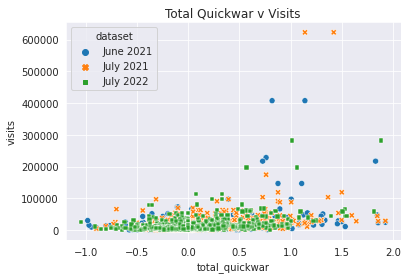

In [58]:
sns.scatterplot(x='total_quickwar', y='visits', data=concatenated,
                hue='dataset', style='dataset').set(title='Total Quickwar v Visits')
plt.show()

In [44]:
concatenated.corr(method = 'pearson')

,player_id,month_x,join_month,year,visits,month_y,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
player_id,1.000000,0.014541,0.014541,0.027364,-0.048743,0.011834,0.006096,-0.047864,-0.018794,-0.043456
month_x,0.014541,1.000000,1.000000,0.492408,0.025285,0.681233,0.031010,-0.052821,0.000679,-0.002596
join_month,0.014541,1.000000,1.000000,0.492408,0.025285,0.681233,0.031010,-0.052821,0.000679,-0.002596
year,0.027364,0.492408,0.492408,1.000000,-0.015417,0.347143,-0.016577,-0.121989,-0.076226,-0.053651
visits,-0.048743,0.025285,0.025285,-0.015417,1.000000,0.022528,0.227143,0.273500,0.338472,0.206761
month_y,0.011834,0.681233,0.681233,0.347143,0.022528,1.000000,0.056783,-0.029178,0.035352,0.034584
hitting_quickwar,0.006096,0.031010,0.031010,-0.016577,0.227143,0.056783,1.000000,-0.037120,0.863326,0.752685
pitching_quickwar,-0.047864,-0.052821,-0.052821,-0.121989,0.273500,-0.029178,-0.037120,1.000000,0.472253,0.250843
total_quickwar,-0.018794,0.000679,0.000679,-0.076226,0.338472,0.035352,0.863326,0.472253,1.000000,0.790596
performance_rank,-0.043456,-0.002596,-0.002596,-0.053651,0.206761,0.034584,0.752685,0.250843,0.790596,1.000000


total corr score is .33